# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156xxx
##### Wiktoria Szarzyńska : 156xxx

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms


### Defining dataset class

In [ ]:
# class JetBotDataset(Dataset):
#     """
#     Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
#     Returns image(rgb), [forward, left] tensor
#     """
#     def __init__(self, root_dir, transform=None):
#         self.samples = []
#         self.transform = transform
        
#         folders = [name for name in os.listdir(root_dir)
#            if os.path.isdir(os.path.join(root_dir, name))]

#         for folder_name in folders:
#             file_name = folder_name + ".csv"
#             csv_path = os.path.join(root_dir, file_name)
#             folder_path = os.path.join(root_dir, folder_name)

#             if not os.path.exists(csv_path):
#                 print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
#                 continue
            
#             try:
#                 df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
#                 df.columns = ["filename", "forward", "left"]

#                 for _, row in df.iterrows():
#                     img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
#                     if not os.path.exists(img_path):
#                         print(f"Warnign: Image file {img_path} not found.")
#                         continue
#                     self.samples.append((img_path, float(row["forward"]), float(row["left"])))
#             except Exception as e:
#                 print(f"Error processing {csv_path}: e")
                
#         print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
#     def __len__(self):
#         return len(self.samples)
        
#     def __getitem__(self, idx):
#         img_path, forward, left = self.samples[idx]
        
#         try:
#             image = PIL.Image.open(img_path).convert("RGB")
#             if self.transform:
#                 image = self.transform(image)

#             return image, torch.tensor([forward, left], dtype=torch.float32)

#         except Exception as e:
#             print(f"Error loading image {img_path}: {e}")
#             placeholder = torch.zeros((3,224,224))
#             return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    

# def get_transforms(augument=True):
#     """Create transformations for training and validation/test datasets.
#     For JetBot camera images (usually 224x224 RGB).
    
#     Args:
#         augment (bool): If True, apply data augmentation for training.
        
#     Returns:
#         torchvision.transforms.Compose object
#     """
#     common_transforms = [
#         transforms.Resize((224, 224)),  # resize all images
#         # transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
#                              std=[0.229, 0.224, 0.225]),
#     ]

#     if augument:
#         train_transforms = [
#             transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
#             # transforms.RandomRotation(degrees=10),
#             # transforms.RandomHorizontalFlip(p=0.5),

#             # Optional realistic distortions:
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),  # Simulate camera blur
#             # transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Simulate lens distortion
#             # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),  # Subtle motion

#             *common_transforms
#         ]
#         return transforms.Compose(train_transforms)
#     else:
#         # No augmentation for validation/test
#         return transforms.Compose(common_transforms)
import os
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import random


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warning: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: {e}")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            # Load image with OpenCV (BGR format)
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor([forward, left], dtype=torch.float32)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)


def cv2_resize(image, size=(224, 224)):
    """Resize image using OpenCV"""
    return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)


def cv2_normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Normalize image using ImageNet statistics"""
    # Convert to float32 and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    # Apply ImageNet normalization
    mean = np.array(mean, dtype=np.float32)
    std = np.array(std, dtype=np.float32)
    
    image = (image - mean) / std
    return image


def cv2_to_tensor(image):
    """Convert numpy array to PyTorch tensor and change from HWC to CHW"""
    # Change from HWC to CHW format
    image = np.transpose(image, (2, 0, 1))
    return torch.from_numpy(image).float()


def cv2_color_jitter(image, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4):
    """Apply color jittering using OpenCV"""
    image = image.copy()
    
    # Brightness adjustment
    if random.random() < 0.4:  # Apply with 40% probability
        brightness_factor = 1.0 + random.uniform(-brightness, brightness)
        image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)
    
    # Contrast adjustment
    if random.random() < 0.8:
        contrast_factor = 1.0 + random.uniform(-contrast, contrast)
        image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)
    
    # Saturation adjustment
    if random.random() < 0.4:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
        saturation_factor = 1.0 + random.uniform(-saturation, saturation)
        hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation_factor, 0, 255)
        image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    # Hue adjustment
    if random.random() < 0.4:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
        hue_factor = random.uniform(-hue, hue) * 180  # Convert to degrees
        hsv[:, :, 0] = (hsv[:, :, 0] + hue_factor) % 180
        image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    return image


def cv2_gaussian_blur(image, kernel_size=3, sigma_range=(0.1, 2.0)):
    """Apply Gaussian blur using OpenCV"""
    sigma = random.uniform(*sigma_range)
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)


def get_transforms(augment=True):
    """Create transformations for training and validation/test datasets.
    For JetBot camera images (usually 224x224 RGB).
    
    Args:
        augment (bool): If True, apply data augmentation for training.
        
    Returns:
        function that applies transformations
    """
    
    def train_transform(image):
        # Apply augmentations
        if random.random() < 1.0:  # Always apply color jitter
            image = cv2_color_jitter(image, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)
        
        if random.random() < 0.5:  # Apply Gaussian blur with 50% probability
            image = cv2_gaussian_blur(image, kernel_size=5)
        
        # Apply common transforms
        image = cv2_resize(image, size=(224, 224))
        image = cv2_normalize(image)
        image = cv2_to_tensor(image)
        
        return image
    
    def val_transform(image):
        # No augmentation for validation/test
        image = cv2_resize(image, size=(224, 224))
        image = cv2_normalize(image)
        image = cv2_to_tensor(image)
        
        return image
    
    if augment:
        return train_transform
    else:
        return val_transform


# Optional: Additional OpenCV-based augmentation functions

def cv2_random_rotation(image, degrees=10):
    """Apply random rotation using OpenCV"""
    angle = random.uniform(-degrees, degrees)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Apply rotation
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, 
                           borderMode=cv2.BORDER_REFLECT_101)
    return rotated


def cv2_random_perspective(image, distortion_scale=0.2):
    """Apply random perspective transformation using OpenCV"""
    h, w = image.shape[:2]
    
    # Define corner points
    pts1 = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    
    # Add random distortion
    max_distortion = min(w, h) * distortion_scale
    pts2 = pts1 + np.random.uniform(-max_distortion, max_distortion, pts1.shape).astype(np.float32)
    
    # Get perspective transform matrix
    M = cv2.getPerspectiveTransform(pts1, pts2)
    
    # Apply perspective transformation
    transformed = cv2.warpPerspective(image, M, (w, h), flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_REFLECT_101)
    return transformed


def cv2_random_affine(image, degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5):
    """Apply random affine transformation using OpenCV"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Random rotation
    angle = random.uniform(-degrees, degrees)
    
    # Random scale
    scale_factor = random.uniform(*scale)
    
    # Get rotation + scale matrix
    M = cv2.getRotationMatrix2D(center, angle, scale_factor)
    
    # Add translation
    tx = random.uniform(-translate[0], translate[0]) * w
    ty = random.uniform(-translate[1], translate[1]) * h
    M[0, 2] += tx
    M[1, 2] += ty
    
    # Add shear (modify the matrix directly)
    shear_x = random.uniform(-shear, shear) * np.pi / 180
    shear_y = random.uniform(-shear, shear) * np.pi / 180
    
    shear_matrix = np.array([[1, np.tan(shear_x), 0],
                           [np.tan(shear_y), 1, 0]], dtype=np.float32)
    
    M = np.dot(shear_matrix, np.vstack([M, [0, 0, 1]]))[:2]
    
    # Apply transformation
    transformed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_REFLECT_101)
    return transformed

In [29]:
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.subset)


In [30]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset
    base_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(base_dataset)

    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    generator = torch.Generator().manual_seed(42)
    train_base, val_base, test_base = random_split(base_dataset, [train_len, val_len, test_len], generator=generator)

    # Wrap with transforms
    train_set = SubsetWithTransform(train_base, transform=train_transform)
    val_set = SubsetWithTransform(val_base, transform=val_test_transform)
    test_set = SubsetWithTransform(test_base, transform=val_test_transform)

    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }



In [31]:
data = create_datasets(root_dir = "dataset/", batch_size=32)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

In [32]:
import matplotlib.pyplot as plt
import torchvision

# Reverse normalization: ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def unnormalize(tensor):
    for t, m, s in zip(tensor, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    return tensor


def show_batch(loader, n_images=8):
    batch = next(iter(loader))  # Get one batch
    images, labels = batch

    images = images[:n_images]  # limit to first N
    labels = labels[:n_images]

    # Unnormalize
    images = torch.stack([unnormalize(img.clone()) for img in images])

    # Create grid
    grid_img = torchvision.utils.make_grid(images, nrow=4)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Training Batch (Augmented + Normalized)")
    plt.axis("off")
    plt.show()

    # Optional: print labels (steering + throttle)
    for i, (fwd, left) in enumerate(labels):
        print(f"Sample {i}: forward = {fwd:.2f}, left = {left:.2f}")



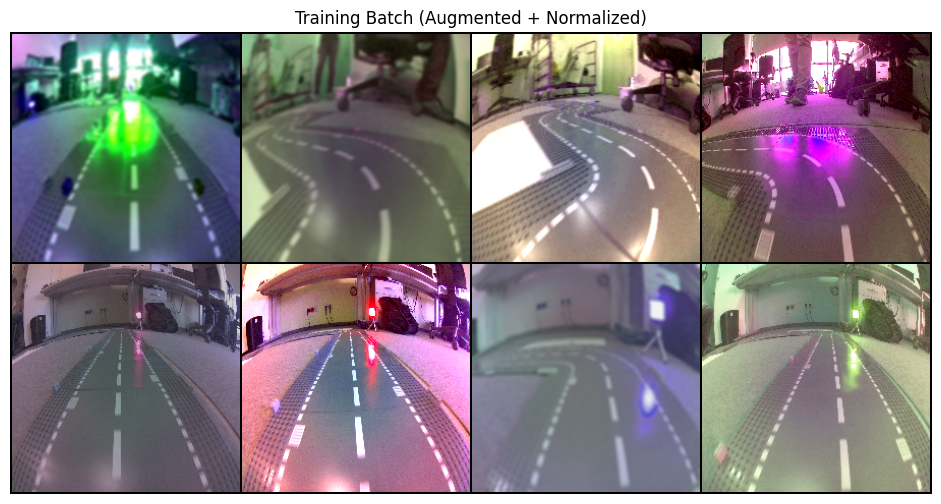

Sample 0: forward = 0.72, left = 0.00
Sample 1: forward = 0.95, left = -1.00
Sample 2: forward = 1.00, left = -1.00
Sample 3: forward = 0.70, left = 0.00
Sample 4: forward = 0.87, left = 0.00
Sample 5: forward = 0.87, left = 0.99
Sample 6: forward = 0.75, left = -1.00
Sample 7: forward = 0.79, left = 0.00


In [33]:
show_batch(train_loader)


In [34]:
def count_control_classes(data_loader):
    left_count = 0
    straight_count = 0
    right_count = 0

    for images, labels in data_loader:
        # labels[:, 1] is the "left" value (since [forward, left])
        left_values = labels[:, 1]

        left_count += (left_values < 0).sum().item()
        straight_count += (left_values == 0).sum().item()
        right_count += (left_values > 0).sum().item()

    total = left_count + straight_count + right_count
    print(f"Total samples: {total}")
    print(f"Left (< 0): {left_count}")
    print(f"Straight (= 0): {straight_count}")
    print(f"Right (> 0): {right_count}")


In [35]:
count_control_classes(train_loader)

Total samples: 182
Left (< 0): 25
Straight (= 0): 119
Right (> 0): 38


In [36]:
import torch.nn as nn
import torch.nn.functional as F

class ModifiedNvidiaNetwork(nn.Module):
    def __init__(self):
        super(ModifiedNvidiaNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  # Add adaptive pooling

        feature_size = 128 * 4 * 4  # matches avgpool output

        self.fc1 = nn.Linear(feature_size, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.avgpool(x)  # ensure fixed spatial size

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model = NvidiaPaperNetwork().to(device)
model = ModifiedNvidiaNetwork().to(device)

Using device: cpu


In [38]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
ModifiedNvidiaNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 365,442


In [39]:
def training(model, train_loader, val_loader, device, epochs=100):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 17
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = F.mse_loss(outputs, targets)
            
            train_loss += float(loss)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = F.mse_loss(outputs, targets)      
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

Epoch 1/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.40it/s, loss=0.376]


Epoch 1/70 - Train loss: 0.439799 - Val loss: 0.342169
New best model saved with val loss: 0.342169


Epoch 2/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=0.285]


Epoch 2/70 - Train loss: 0.270044 - Val loss: 0.256923
New best model saved with val loss: 0.256923


Epoch 3/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s, loss=0.225]


Epoch 3/70 - Train loss: 0.253700 - Val loss: 0.211991
New best model saved with val loss: 0.211991


Epoch 4/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=0.231]


Epoch 4/70 - Train loss: 0.245099 - Val loss: 0.213620


Epoch 5/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s, loss=0.237]


Epoch 5/70 - Train loss: 0.232855 - Val loss: 0.212273


Epoch 6/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s, loss=0.251]


Epoch 6/70 - Train loss: 0.230316 - Val loss: 0.222832


Epoch 7/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s, loss=0.24] 


Epoch 7/70 - Train loss: 0.227330 - Val loss: 0.214011


Epoch 8/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.84it/s, loss=0.222]


Epoch 8/70 - Train loss: 0.231076 - Val loss: 0.203399
New best model saved with val loss: 0.203399


Epoch 9/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, loss=0.222]


Epoch 9/70 - Train loss: 0.232831 - Val loss: 0.204865


Epoch 10/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s, loss=0.215]


Epoch 10/70 - Train loss: 0.222645 - Val loss: 0.197905
New best model saved with val loss: 0.197905


Epoch 11/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, loss=0.223]


Epoch 11/70 - Train loss: 0.213042 - Val loss: 0.203782


Epoch 12/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s, loss=0.219]


Epoch 12/70 - Train loss: 0.216589 - Val loss: 0.199888


Epoch 13/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s, loss=0.211]


Epoch 13/70 - Train loss: 0.212577 - Val loss: 0.195670
New best model saved with val loss: 0.195670


Epoch 14/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s, loss=0.215]


Epoch 14/70 - Train loss: 0.217155 - Val loss: 0.200150


Epoch 15/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s, loss=0.21]


Epoch 15/70 - Train loss: 0.223454 - Val loss: 0.194946
New best model saved with val loss: 0.194946


Epoch 16/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=0.217]


Epoch 16/70 - Train loss: 0.223380 - Val loss: 0.198986


Epoch 17/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=0.218]


Epoch 17/70 - Train loss: 0.223707 - Val loss: 0.200978


Epoch 18/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, loss=0.21] 


Epoch 18/70 - Train loss: 0.210999 - Val loss: 0.194206
New best model saved with val loss: 0.194206


Epoch 19/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.40it/s, loss=0.218]


Epoch 19/70 - Train loss: 0.219007 - Val loss: 0.199539


Epoch 20/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s, loss=0.219]


Epoch 20/70 - Train loss: 0.212593 - Val loss: 0.198710


Epoch 21/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=0.209]


Epoch 21/70 - Train loss: 0.212613 - Val loss: 0.193529
New best model saved with val loss: 0.193529


Epoch 22/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=0.211]


Epoch 22/70 - Train loss: 0.203084 - Val loss: 0.192970
New best model saved with val loss: 0.192970


Epoch 23/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.18it/s, loss=0.211]


Epoch 23/70 - Train loss: 0.212236 - Val loss: 0.195212


Epoch 24/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s, loss=0.216]


Epoch 24/70 - Train loss: 0.205126 - Val loss: 0.198875


Epoch 25/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s, loss=0.214]


Epoch 25/70 - Train loss: 0.210167 - Val loss: 0.197670


Epoch 26/70 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, loss=0.209]


Epoch 26/70 - Train loss: 0.207188 - Val loss: 0.191416
New best model saved with val loss: 0.191416


Epoch 27/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.91it/s, loss=0.208]


Epoch 27/70 - Train loss: 0.200083 - Val loss: 0.193930


Epoch 28/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.65it/s, loss=0.192]


Epoch 28/70 - Train loss: 0.198428 - Val loss: 0.179807
New best model saved with val loss: 0.179807


Epoch 29/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s, loss=0.197]


Epoch 29/70 - Train loss: 0.199910 - Val loss: 0.188927


Epoch 30/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s, loss=0.17] 


Epoch 30/70 - Train loss: 0.201634 - Val loss: 0.164184
New best model saved with val loss: 0.164184


Epoch 31/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.60it/s, loss=0.191]


Epoch 31/70 - Train loss: 0.195239 - Val loss: 0.181284


Epoch 32/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=0.175]


Epoch 32/70 - Train loss: 0.192203 - Val loss: 0.167687


Epoch 33/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, loss=0.169]


Epoch 33/70 - Train loss: 0.191533 - Val loss: 0.167734


Epoch 34/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.82it/s, loss=0.173]


Epoch 34/70 - Train loss: 0.185542 - Val loss: 0.165227


Epoch 35/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.75it/s, loss=0.174]


Epoch 35/70 - Train loss: 0.181133 - Val loss: 0.168743


Epoch 36/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.84it/s, loss=0.163]


Epoch 36/70 - Train loss: 0.197117 - Val loss: 0.162613
New best model saved with val loss: 0.162613


Epoch 37/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, loss=0.14] 


Epoch 37/70 - Train loss: 0.175132 - Val loss: 0.141173
New best model saved with val loss: 0.141173


Epoch 38/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s, loss=0.168]


Epoch 38/70 - Train loss: 0.173101 - Val loss: 0.161518


Epoch 39/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s, loss=0.147]


Epoch 39/70 - Train loss: 0.179394 - Val loss: 0.146844


Epoch 40/70 [Test]: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s, loss=0.131]


Epoch 40/70 - Train loss: 0.177926 - Val loss: 0.137538
New best model saved with val loss: 0.137538


Epoch 41/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s, loss=0.129]


Epoch 41/70 - Train loss: 0.171481 - Val loss: 0.130616
New best model saved with val loss: 0.130616


Epoch 42/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s, loss=0.126]


Epoch 42/70 - Train loss: 0.170553 - Val loss: 0.131492


Epoch 43/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=0.12] 


Epoch 43/70 - Train loss: 0.169056 - Val loss: 0.125954
New best model saved with val loss: 0.125954


Epoch 44/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s, loss=0.121]


Epoch 44/70 - Train loss: 0.164609 - Val loss: 0.119048
New best model saved with val loss: 0.119048


Epoch 45/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, loss=0.132]


Epoch 45/70 - Train loss: 0.171670 - Val loss: 0.136555


Epoch 46/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s, loss=0.111]


Epoch 46/70 - Train loss: 0.158082 - Val loss: 0.110948
New best model saved with val loss: 0.110948


Epoch 47/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.91it/s, loss=0.14] 


Epoch 47/70 - Train loss: 0.161621 - Val loss: 0.132229


Epoch 48/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s, loss=0.109]


Epoch 48/70 - Train loss: 0.158710 - Val loss: 0.109347
New best model saved with val loss: 0.109347


Epoch 49/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.74it/s, loss=0.12] 


Epoch 49/70 - Train loss: 0.147324 - Val loss: 0.113886


Epoch 50/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s, loss=0.139]


Epoch 50/70 - Train loss: 0.155500 - Val loss: 0.129226


Epoch 51/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s, loss=0.0801]


Epoch 51/70 - Train loss: 0.150157 - Val loss: 0.089002
New best model saved with val loss: 0.089002


Epoch 52/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s, loss=0.114] 


Epoch 52/70 - Train loss: 0.151552 - Val loss: 0.106098


Epoch 53/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s, loss=0.106]


Epoch 53/70 - Train loss: 0.142650 - Val loss: 0.110556


Epoch 54/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s, loss=0.079] 


Epoch 54/70 - Train loss: 0.145009 - Val loss: 0.085712
New best model saved with val loss: 0.085712


Epoch 55/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s, loss=0.113]


Epoch 55/70 - Train loss: 0.140451 - Val loss: 0.108882


Epoch 56/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=0.0907]


Epoch 56/70 - Train loss: 0.141933 - Val loss: 0.092106


Epoch 57/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.95it/s, loss=0.101]


Epoch 57/70 - Train loss: 0.135054 - Val loss: 0.104120


Epoch 58/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s, loss=0.099] 


Epoch 58/70 - Train loss: 0.134486 - Val loss: 0.092346


Epoch 59/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s, loss=0.0921]


Epoch 59/70 - Train loss: 0.120775 - Val loss: 0.094046


Epoch 60/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s, loss=0.102] 


Epoch 60/70 - Train loss: 0.120725 - Val loss: 0.096681


Epoch 61/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, loss=0.0771]


Epoch 61/70 - Train loss: 0.133896 - Val loss: 0.083086
New best model saved with val loss: 0.083086


Epoch 62/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s, loss=0.0815]


Epoch 62/70 - Train loss: 0.121013 - Val loss: 0.086704


Epoch 63/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.79it/s, loss=0.0951]


Epoch 63/70 - Train loss: 0.131397 - Val loss: 0.098269


Epoch 64/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 12.26it/s, loss=0.0985]


Epoch 64/70 - Train loss: 0.115517 - Val loss: 0.089911


Epoch 65/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=0.0918]


Epoch 65/70 - Train loss: 0.118415 - Val loss: 0.104100


Epoch 66/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s, loss=0.0671]


Epoch 66/70 - Train loss: 0.143396 - Val loss: 0.076223
New best model saved with val loss: 0.076223


Epoch 67/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s, loss=0.0959]


Epoch 67/70 - Train loss: 0.146695 - Val loss: 0.097811


Epoch 68/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s, loss=0.0774]


Epoch 68/70 - Train loss: 0.123571 - Val loss: 0.082227


Epoch 69/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s, loss=0.0858]


Epoch 69/70 - Train loss: 0.123818 - Val loss: 0.090338


Epoch 70/70 [Test]: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s, loss=0.0597]


Epoch 70/70 - Train loss: 0.118601 - Val loss: 0.076040
New best model saved with val loss: 0.076040
Training completed. Best val loss: 0.076040


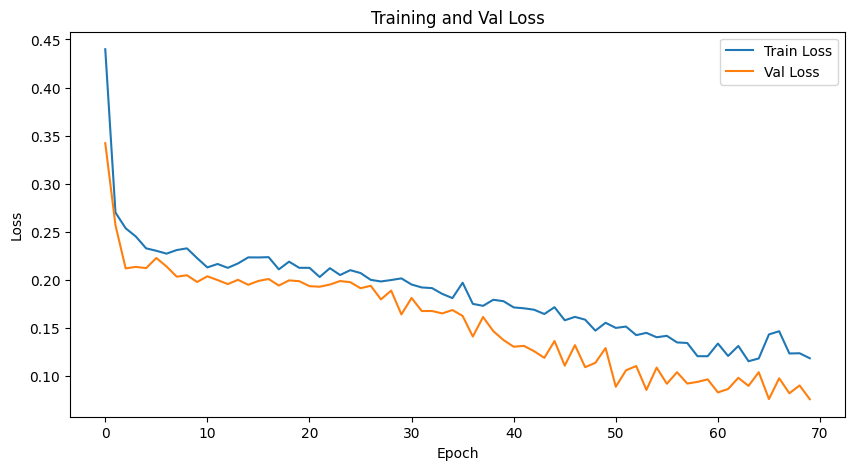

In [40]:
best_model_path = training(model, train_loader, test_loader, device, epochs=70)

# Load the best model
# model.load_state_dict(torch.load(best_model_path))

In [41]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def evaluate_model_detailed(model, test_loader, device):
    """
    Evaluate the model on the test set, compute final MSE loss and MAE per output,
    and visualize predictions vs ground truth if output dim is 2.
    """
    model.eval()
    all_targets = []
    all_predictions = []
    test_loss_sum = 0.0
    total_samples = 0

    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc="Evaluating")

        for images, targets in test_iterator:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)

            loss = F.mse_loss(outputs, targets, reduction='sum')
            test_loss_sum += loss.item()

            batch_size = images.size(0)
            total_samples += batch_size

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

            test_iterator.set_postfix(loss=loss.item() / batch_size)

    final_test_loss = test_loss_sum / total_samples
    print(f"Final test loss: {final_test_loss:.6f}")

    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    mae_per_output = np.mean(np.abs(all_predictions - all_targets), axis=0)
    print(f"Mean Absolute Error per output: {mae_per_output}")

    if all_predictions.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(all_targets[:, 0], all_targets[:, 1], c='blue', alpha=0.5, label='Ground Truth')
        plt.scatter(all_predictions[:, 0], all_predictions[:, 1], c='red', alpha=0.5, label='Predictions')
        plt.xlabel('Forward')
        plt.ylabel('Left')
        plt.title('Predictions vs Ground Truth')
        plt.legend()
        plt.grid(True)
        plt.show()

    return final_test_loss, mae_per_output


def train_and_evaluate_early_stopping(model, train_loader, val_loader, test_loader,
                                      device='cuda' if torch.cuda.is_available() else 'cpu',
                                      epochs=50, lr=1e-3, patience=15):
    model = model.to(device)
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses_mse = []
    val_losses_mse = []
    val_losses_mae = []

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion_mse(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses_mse.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss_mse = 0.0
        running_val_loss_mae = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss_mse = criterion_mse(outputs, targets)
                loss_mae = criterion_mae(outputs, targets)
                running_val_loss_mse += loss_mse.item() * inputs.size(0)
                running_val_loss_mae += loss_mae.item() * inputs.size(0)

        avg_val_loss_mse = running_val_loss_mse / len(val_loader.dataset)
        avg_val_loss_mae = running_val_loss_mae / len(val_loader.dataset)

        val_losses_mse.append(avg_val_loss_mse)
        val_losses_mae.append(avg_val_loss_mae)

        print(f"Epoch {epoch+1}/{epochs} - Train MSE: {avg_train_loss:.4f} - Val MSE: {avg_val_loss_mse:.4f} - Val MAE: {avg_val_loss_mae:.4f}")

        if avg_val_loss_mse < best_val_loss:
            best_val_loss = avg_val_loss_mse
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best weights after early stopping
    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.plot(val_losses_mae, label='Validation MAE Loss')
    plt.title('Training & Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set with detailed function (MSE, MAE per output, and plot)
    final_test_loss, mae_per_output = evaluate_model_detailed(model, test_loader, device)

    print(f"\n✅ Final Test MSE Loss: {final_test_loss:.4f}")
    print(f"✅ Mean Absolute Error per output: {mae_per_output}")

    return model


In [42]:
def visualize_predictions(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            for i in range(min(n, images.size(0))):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                true = labels[i].cpu().numpy()
                pred = outputs[i].cpu().numpy()
                
                plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
                plt.title(f"GT: {true.round(2)} | Pred: {pred.round(2)}")
                plt.axis("off")
                plt.show()

                shown += 1
                if shown >= n:
                    return


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


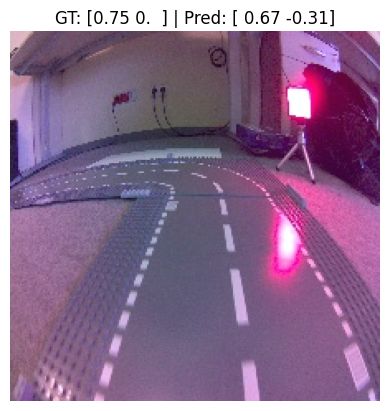

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


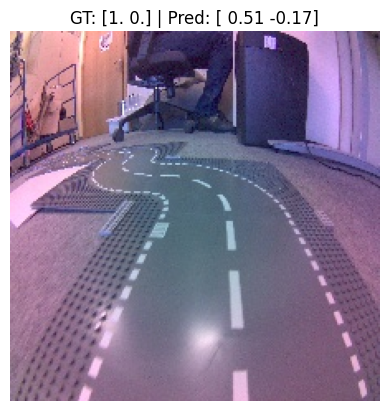

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


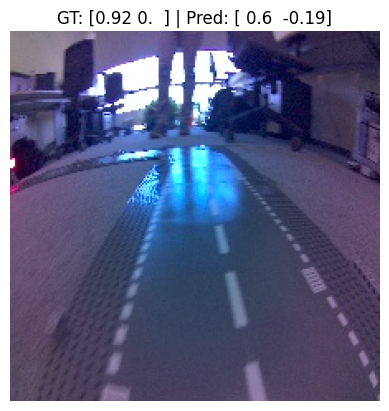

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


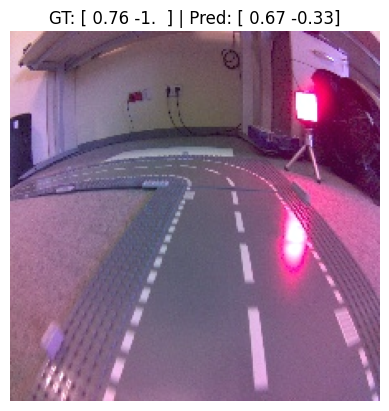

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


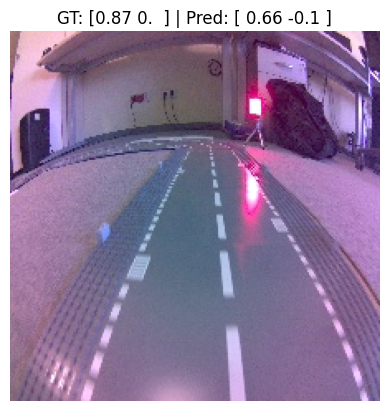

In [43]:
model.load_state_dict(torch.load(best_model_path))

visualize_predictions(model, test_loader)


In [44]:
# import matplotlib.pyplot as plt
# import torch

# def plot_predictions_vs_ground_truth(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', max_points=500):
#     model.eval()
#     model.to(device)

#     true_left = []
#     true_forward = []
#     pred_left = []
#     pred_forward = []

#     with torch.no_grad():
#         count = 0
#         for images, targets in test_loader:
#             images, targets = images.to(device), targets.to(device)
#             outputs = model(images)

#             # Collect true and predicted values
#             true_left.extend(targets[:, 1].cpu().numpy())
#             true_forward.extend(targets[:, 0].cpu().numpy())
#             pred_left.extend(outputs[:, 1].cpu().numpy())
#             pred_forward.extend(outputs[:, 0].cpu().numpy())

#             count += images.size(0)
#             if count >= max_points:
#                 break

#     plt.figure(figsize=(8, 8))
#     plt.scatter(true_left, true_forward, color='blue', alpha=0.5, label='True')
#     plt.scatter(pred_left, pred_forward, color='red', alpha=0.5, label='Predicted')

#     plt.xlabel('Left Value')
#     plt.ylabel('Forward Value')
#     plt.title('True vs Predicted: Left vs Forward')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [45]:
import matplotlib.pyplot as plt
import torch

def plot_predictions_vs_ground_truth(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', max_points=500):
    model.eval()
    model.to(device)

    true_left = []
    true_forward = []
    pred_left = []
    pred_forward = []

    with torch.no_grad():
        count = 0
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            # Collect true and predicted values
            true_left.extend(targets[:, 1].cpu().numpy())
            true_forward.extend(targets[:, 0].cpu().numpy())

            # Round predicted left before collecting
            pred_left.extend(outputs[:, 1].cpu().numpy())
            pred_forward.extend(outputs[:, 0].cpu().numpy())

            count += images.size(0)
            if count >= max_points:
                break

    plt.figure(figsize=(8, 8))
    plt.scatter(true_left, true_forward, color='blue', alpha=0.5, label='True')
    plt.scatter(pred_left, pred_forward, color='red', alpha=0.5, label='Predicted ')

    plt.xlabel('Left Value')
    plt.ylabel('Forward Value')
    plt.title('True vs Predicted: Left vs Forward')
    plt.legend()
    plt.grid(True)
    plt.show()


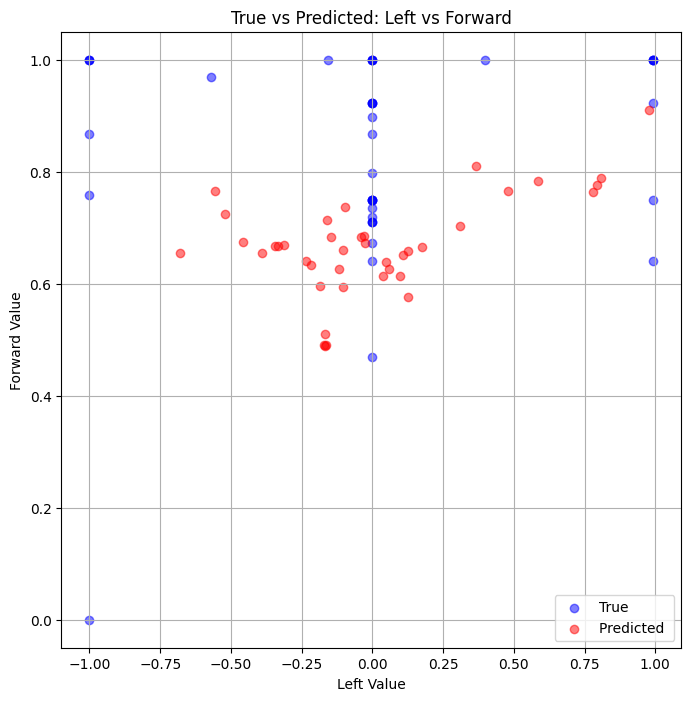

In [46]:
plot_predictions_vs_ground_truth(model, test_loader)


In [47]:
import torch
import onnx

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval()
model.to(device)

# Create a dummy input tensor with the same shape as the model expects
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # batch size 1

onnx_model_path = "model_jetbot.onnx"

torch.onnx.export(
    model,                   # model being run
    dummy_input,             # model input (or a tuple for multiple inputs)
    onnx_model_path,         # where to save the model
    opset_version=11,        # ONNX version
    input_names=['input'],   # input layer names
    output_names=['output'], # output layer names
    dynamic_axes={
        'input': {0: 'batch_size'},    # variable length axes
        'output': {0: 'batch_size'}
    },
    do_constant_folding=True,  # optimization
    verbose=False              # set to True if you want detailed export log
)

# Load and check the ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")


Model has been successfully exported to ONNX format!


In [ ]:
import cv2
import numpy as np
import onnxruntime as rt
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class AI:
    def __init__(self, model_path: str):
        # self.sess = rt.InferenceSession(model_path, providers=[
        #     'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name

        # Define same preprocessing used in training
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy to PIL
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert to tensor and rescale to [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        """a
        Preprocess BGR image to match model input.
        Converts BGR to RGB, applies resizing, normalization, etc.
        Returns a numpy array of shape (1, 3, 224, 224) with dtype float32.
        """
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)  # Apply transforms
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        return img_tensor.numpy().astype(np.float32)

    def postprocess(self, detections: np.ndarray) -> np.ndarray:
        """
        Postprocess model outputs.
        Converts to 1D numpy array if needed.
        """
        return detections.squeeze()  # Should be shape (2,)

    def predict(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)

        assert inputs.dtype == np.float32
        assert inputs.shape == (1, 3, 224, 224)

        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        outputs = self.postprocess(detections)

        assert outputs.dtype == np.float32
        assert outputs.shape == (2,)
        assert outputs.max() < 1.0
        assert outputs.min() > -1.0

        return outputs


def check(img_name, model):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        image_path = f'camera/{img_name}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image '{img_name}' not found in camera/ directory!")

    # model_path = 'model_jetbot.onnx'
    # model.load_state_dict(torch.load(best_model_path))

    # ai = AI(model_path)
    model 
    prediction = ai.predict(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()

In [ ]:
def visualize_predictions(model, img, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
    for img in img:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        for i in range(min(n, images.size(0))):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            true = labels[i].cpu().numpy()
            pred = outputs[i].cpu().numpy()
            
            plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
            plt.title(f"GT: {true.round(2)} | Pred: {pred.round(2)}")
            plt.axis("off")
            plt.show()

            shown += 1
            if shown >= n:
                return
